In [0]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O data.tgz && tar -xf data.tgz && rm -rf data.tgz && mv lfw-deepfunneled dataset
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt

--2019-02-21 07:53:23--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘data.tgz’

data.tgz            100%[===================>] 103.72M  30.7MB/s    in 4.7s    

2019-02-21 07:53:33 (22.0 MB/s) - ‘data.tgz’ saved [108761145/108761145]

--2019-02-21 07:53:36--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

lfw_attributes.txt  100%[===================>]  14.19M  6.08MB/s    in 2.3s    

2019-02-21 07:53:39 (6.08 MB/s) 

In [0]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.nn import Module
import torch.nn as Layers
import torch.nn.functional as F
from torch import optim as Opt
from skimage import io
from torchvision import models

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls

sample_data


In [0]:
data = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1)

In [0]:
data.head()

,#,person,imagenum,Male,Asian,White,Black,Baby,Child,Youth,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,Aaron Eckhart,1,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.195580,-0.835609,-0.351468,...,1.166118,-1.164916,-1.139990,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609,NaN
1,Aaron Guiel,1,0.169851,-0.982408,0.422709,-1.282184,-1.360060,-0.867002,-0.452293,-0.197521,...,-0.397680,0.874160,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.666760,-0.496559,NaN
2,Aaron Patterson,1,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,...,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231,NaN
3,Aaron Peirsol,1,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,...,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025,NaN
4,Aaron Peirsol,2,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,...,-0.955283,0.119113,-1.128176,-3.161048,0.082680,-0.439614,-0.359859,-0.760774,-0.410152,NaN


In [0]:
smiling = data[['#', 'person', 'Smiling']]
smiling.columns = ['person', 'number', 'smiling']

In [0]:
smiling.person = smiling.person.str.replace(' ', '_')
smiling["photo"] = smiling.iloc[:, :2].apply(lambda x: "{}_{}.jpg".format(x[0], str(x[1]).zfill(4)), axis=1)
smiling.iloc[np.argsort(smiling.smiling)[:10], :]

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,person,number,smiling,photo
12609,Vanessa_Incontrada,4,-2.953572,Vanessa_Incontrada_0004.jpg
1045,Azra_Akin,3,-2.898542,Azra_Akin_0003.jpg
9005,Michelle_Rodriguez,2,-2.888022,Michelle_Rodriguez_0002.jpg
13034,Yekaterina_Guseva,1,-2.872781,Yekaterina_Guseva_0001.jpg
5624,Jaime_Pressly,1,-2.860385,Jaime_Pressly_0001.jpg
4681,Gloria_Macapagal_Arroyo,38,-2.836526,Gloria_Macapagal_Arroyo_0038.jpg
9755,Paris_Hilton,1,-2.818490,Paris_Hilton_0001.jpg
1955,Cheryl_James,1,-2.817712,Cheryl_James_0001.jpg
6151,Jennifer_Lopez,13,-2.807535,Jennifer_Lopez_0013.jpg
983,Ashlea_Talbot,1,-2.790396,Ashlea_Talbot_0001.jpg


In [0]:
def show_im(person, photo_path):
  img = cv2.imread(f"dataset/{person}/{photo_path}")
  print(img.shape)
  return 
  plt.imshow(img[..., [2, 1, 0]])
  plt.show();

In [0]:
for i in range(3):
  num_rand = np.random.randint(0, data.shape[0])
  photo = smiling.loc[num_rand, ["person", "photo"]]
  show_im(*photo)

(250, 250, 3)
(250, 250, 3)
(250, 250, 3)


In [0]:
class Images(Dataset):
  def __init__(self, root_dir, data, transforms=None):
    self.data = data.reset_index().drop("index", axis=1)
    self.transforms = transforms
    self.root_dir = root_dir
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name = self.root_dir + "/".join(self.data.loc[idx, ["person", "photo"]])
    img = io.imread(img_name) / 255
    img = cv2.resize(img, (48, 48))
    
    if self.transforms:
      img = self.transforms(img)
      
    return img

In [0]:
transform = T.Compose([
#     ToPILImage(),
#     Resize((28, 28)),
    T.ToTensor(),
#     Resize(28),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:

train, test = train_test_split(smiling, test_size=0.01)
# train = smiling[:40]
train = Images("dataset/", train, transform)
# test = Images("dataset/", test, transform)
train = DataLoader(train, batch_size=32, shuffle=True, num_workers=4)
# test = DataLoader(test, batch_size=32, shuffle=True, num_workers=4)

In [0]:
for i in train:
  print(i.shape)
  break

torch.Size([32, 3, 64, 64])


In [0]:
incept = models.Inception3()

In [0]:
incept.modules

In [0]:
class BasicConv2d(Module):
  def __init__(self, D_in, D_out, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.conv = Layers.Conv2d(D_in, D_out, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn = Layers.BatchNorm2d(D_out, eps=0.001)
    
  def forward(self, x):
    x = self.bn(self.conv(x))
    
    return x

class AutoEnc_a_forward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(3, 64)
    self.conv_2 = BasicConv2d(64, 192)
  
  def forward(self, x):
    x = F.max_pool2d(self.conv_1(x), 2) # 64 32 32
    x = F.max_pool2d(self.conv_2(x), 2) # 192 16 16
    
    return x # 192 16 16

class AutoEnc_b_forward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(192, 480)
    self.conv_2 = BasicConv2d(480, 256)
    self.conv_3 = BasicConv2d(256, 64)
    self.conv_4 = BasicConv2d(64, 32)
  
  def forward(self, x):
    x = self.conv_2(self.conv_1(x))
    x = self.conv_4(self.conv_3(x))
    
    return F.max_pool2d(x, 2) # 32 8 8

class AutoEnc_c_forward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(32, 192)
    self.conv_2 = BasicConv2d(192, 480)
    self.conv_3 = BasicConv2d(480, 224)
    self.conv_4 = BasicConv2d(224, 32)
  
  def forward(self, x):
    x = self.conv_2(self.conv_1(x))
    x = self.conv_4(self.conv_3(x))
    
    return F.max_pool2d(x, 2) # 32 4 4
  
class AutoEnc_d_forward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(32, 192)
    self.conv_2 = BasicConv2d(192, 256)
    self.conv_3 = BasicConv2d(256, 480)
    self.conv_4 = BasicConv2d(480, 832)
    self.conv_5 = BasicConv2d(832, 512)
    self.conv_6 = BasicConv2d(512, 1024)
  
  def forward(self, x):
    x = self.conv_2(self.conv_1(x))
    x = self.conv_4(self.conv_3(x))
    x = self.conv_6(self.conv_5(x))
    
    return F.avg_pool2d(x, 4) # 1024 1 1

class AutoEnc_d_backward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(1024, 512)
    self.conv_2 = BasicConv2d(512, 832)
    self.conv_3 = BasicConv2d(832, 480)
    self.conv_4 = BasicConv2d(480, 256)
    self.conv_5 = BasicConv2d(256, 192)
    self.conv_6 = BasicConv2d(192, 32)
  
  def forward(self, x):
    x = F.interpolate(x, 4) # 1024 4 4
    x = self.conv_2(self.conv_1(x))
    x = self.conv_4(self.conv_3(x))
    x = self.conv_6(self.conv_5(x))
    
    return x # 32 4 4

class AutoEnc_c_backward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(32, 224)
    self.conv_2 = BasicConv2d(224, 480)
    self.conv_3 = BasicConv2d(480, 192)
    self.conv_4 = BasicConv2d(192, 32)
 
  def forward(self, x):
    x = F.interpolate(x, 8) # 32 8 8
    x = self.conv_2(self.conv_1(x))
    x = self.conv_4(self.conv_3(x))
    
    return x # 32 8 8
  
class AutoEnc_b_backward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(32, 64)
    self.conv_2 = BasicConv2d(64, 256)
    self.conv_3 = BasicConv2d(256, 480)
    self.conv_4 = BasicConv2d(480, 192)
  
  def forward(self, x):
    x = F.interpolate(x, 16) # 32 16 16
    x = self.conv_2(self.conv_1(x))
    x = self.conv_4(self.conv_3(x))
    
    return x # 192 16 16

class AutoEnc_a_backward(Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicConv2d(192, 64)
    self.conv_2 = BasicConv2d(64, 3)
    
  def forward(self, x):
    x = F.interpolate(x, 32) # 192 32 32
    x = self.conv_1(x) # 64 32 32
    x = F.interpolate(x, 64) # 64 64 64
    x = self.conv_2(x) 
    
    return x # 3 64 64
    
class AutoEncoder(Module):
  def __init__(self):
    super().__init__()
    self.enc = Layers.Sequential(
        AutoEnc_a_forward(), # 
        AutoEnc_b_forward(),
        AutoEnc_c_forward(),
        AutoEnc_d_forward()
    )
    self.fc_forward = Layers.Linear(1024, 100) 
    self.dec = Layers.Sequential(
        AutoEnc_d_backward(),
        AutoEnc_c_backward(),
        AutoEnc_b_backward(),
        AutoEnc_a_backward(),
    )
    self.fc_backward = Layers.Linear(100, 1024)
    
  def forward(self, x):
    x = self.enc(x)
    x = x.view(-1, 1024)
    enc = F.relu(self.fc_forward(x))
    
    x = F.relu(self.fc_backward(enc))
    x = x.view(-1, 1024, 1, 1)
    dec = self.dec(x)
    
    return enc, dec

In [0]:
class AutoEncoder(Module):
  def __init__(self, D_in, H_1, H_2, H_3, H_4, L_1, L_2):
    super().__init__()
    self.conv_1 = Layers.Conv2d(D_in, H_1, kernel_size=3, stride=1, padding=1)
    self.batch_norm_1 = Layers.BatchNorm2d(H_1, eps=0.01)
    self.conv_2 = Layers.Conv2d(H_1, H_2, kernel_size=3, stride=1, padding=1)
    self.batch_norm_2 = Layers.BatchNorm2d(H_2, eps=0.01)
    self.conv_3 = Layers.Conv2d(H_2, H_3, kernel_size=3, stride=1, padding=1)
    self.batch_norm_3 = Layers.BatchNorm2d(H_3, eps=0.01)
    self.conv_4 = Layers.Conv2d(H_3, H_4, 3, stride=1, padding=1)
    self.batch_norm_4 = Layers.BatchNorm2d(H_4, eps=0.01)
    self.linear_1 = Layers.Linear(1024 * 4 * 4, L_1)
#     self.batch_norm_5 = Layers.BatchNorm2d(L_1)
    self.linear_2 = Layers.Linear(L_1, L_2)
    
    self.linear_3 = Layers.Linear(L_2, L_1)
#     self.batch_norm_5 = Layers.BatchNorm2d(L_1)
    self.linear_4 = Layers.Linear(L_1, 1024 * 4 * 4)
    self.batch_norm_5 = Layers.BatchNorm2d(H_4, eps=0.01)
    self.conv_5 = Layers.Conv2d(H_4, H_3, 3, stride=1, padding=1)
    self.batch_norm_6 = Layers.BatchNorm2d(H_3, eps=0.01)
    self.conv_6 = Layers.Conv2d(H_3, H_2, 3, stride=1, padding=1)
    self.batch_norm_7 = Layers.BatchNorm2d(H_2, eps=0.01)
    self.conv_7 = Layers.Conv2d(H_2, H_1, 3, stride=1, padding=1)
    self.batch_norm_8 = Layers.BatchNorm2d(H_1, eps=0.01)
    self.conv_8 = Layers.Conv2d(H_1, D_in, 3, stride=1, padding=1)
  
  
  def forward(self, x):
    enc = F.max_pool2d(self.batch_norm_1(self.conv_1(x)), 2) # H_1 64 64
    enc = F.max_pool2d(self.batch_norm_2(self.conv_2(enc)), 2) # H_2 32 32
    enc = F.max_pool2d(self.batch_norm_3(self.conv_3(enc)), 2) # H_3 16 16
    enc = F.max_pool2d(self.batch_norm_4(self.conv_4(enc)), 2) # D_in 8 8
#     print(enc.size())
    enc = enc.view(-1, 1024 * 4 * 4)
#     print(enc.size())
    enc = F.relu(self.linear_1(enc))
#     enc = self.batch_norm_5(enc)
#     enc = F.dropout2d(enc, 0.3)
    enc = F.relu(self.linear_2(enc))
#     print(enc.size())
    dec = F.relu(self.linear_3(enc))
#     dec = self.batch_norm_6(dec)
#     dec = F.dropout2d(dec, 0.3)
    dec = F.relu(self.linear_4(dec))
#     print(dec.size())
    dec = dec.view(-1, 1024, 4, 4)
    dec = self.batch_norm_5(dec)
    dec = F.interpolate(self.batch_norm_6(self.conv_5(dec)), 8)#, mode="bilinear", align_corners=True)) # H_3 8 8
    dec = F.interpolate(self.batch_norm_7(self.conv_6(dec)), 16)#, mode="bilinear", align_corners=True)) # H_2 16 16
    dec = F.interpolate(self.batch_norm_8(self.conv_7(dec)), 32)#, mode="bilinear", align_corners=True)) # H_1 32 32
    dec = F.interpolate(self.conv_8(dec), 64)#, mode="bilinear", align_corners=True)) # D_in 64 64
    
    return enc, dec

In [0]:
def dump_model(model, path, epoch, optimizer, loss):
  import torch
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path) # "gdrive/My Drive/encoder_project/model_checkpoint.model"
D_in, H_1, H_2, H_3, H_4, L_1, L_2 = 3, 128, 256, 512, 1024, 1000, 2000
def load_model(path):
  import torch
  model = AutoEncoder(D_in, H_1, H_2, H_3, H_4, L_1, L_2).cuda().double()
  optimizer = Opt.SGD(model.parameters(), lr=0.01)

  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  
  return model, optimizer, epoch, loss

In [0]:
try:
  model
except NameError:
  model, optimizer, _, __ = load_model("gdrive/My Drive/encoder_project/model_light_checkpoint.model")

In [0]:

# model = AutoEncoder(D_in, H_1, H_2, H_3, H_4, L_1, L_2).cuda().double()
# model = AutoEncoder().cuda().double()

In [0]:
# def init_weights(m):
#     if type(m) == Layers.Linear:
#         Layers.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
#     if type(m) == Layers.Conv2d:
#       Layers.init.xavier_uniform_(m.weight)
#       m.bias.data.fill_(0.01)
        
# model.apply(init_weights)
        
criterion = Layers.MSELoss()
# optimizer = Opt.SGD(model.parameters(), lr=0.01)

In [0]:
def fit(epoch, model, optimizer, data_loader, criterion, phase="training"):
  if phase == "training":
    model.train()
  if phase == "validation":
    model.eval()
  running_loss = 0.0
  running_correct = 0.0
  for batch_idx, data in enumerate(data_loader):
    data, target = data.cuda(), data.cuda()
    if phase == "training":
      optimizer.zero_grad()
    _, output = model(data)
    loss = criterion(output, target)
    
    running_loss += loss
    if phase == "training":
      loss.backward()
      optimizer.step()
  
  loss = running_loss / len(data_loader.dataset)
  print(f"{epoch}: {phase} loss is {loss}")
  
  return loss

122: training loss is 0.0006582567285795026
123: training loss is 0.0006565410257179052
124: training loss is 0.0006559574996580905
125: training loss is 0.0006544097384997903
126: training loss is 0.0006554175169849274
127: training loss is 0.000652015248521907
128: training loss is 0.0006517830468452028
129: training loss is 0.0006510820804584875
130: training loss is 0.000650133866715932
131: training loss is 0.0006492871023101033
132: training loss is 0.0006481354743760668
133: training loss is 0.0006475442088864707
134: training loss is 0.0006464678018250889
135: training loss is 0.0006467942113896713
136: training loss is 0.0006442924348973839
137: training loss is 0.0006449412255925471
138: training loss is 0.0006445417386787156
139: training loss is 0.0006454646118137808
140: training loss is 0.0006415563540702887
141: training loss is 0.0006423640341512224
142: training loss is 0.0006411090347478198
143: training loss is 0.0006379889465776752
144: training loss is 0.0006378033

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


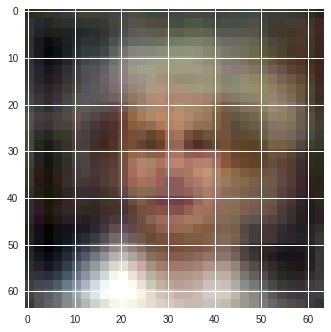

151: training loss is 0.0006329402791263046
152: training loss is 0.000634304434852711


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(se

KeyboardInterrupt: ignored

BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [0]:
train_loss = []
val_loss = []

for epoch in range(_, 400):
  epoch_loss = fit(epoch, model, optimizer, train, criterion, phase="training")
  dump_model(model, "gdrive/My Drive/encoder_project/model_light_checkpoint.model", 
             epoch, optimizer, epoch_loss)
  if epoch % 30 == 0:
    for i in train:
      img = i
      break
    img = img[:1]
    _ , pred = model(img.cuda())
    plt.imshow(np.rot90(pred[0].detach().cpu().numpy().T, k=3))
    plt.show();
#   test_loss = fit(epoch, model, test, criterion, phase="validation")
#   train_loss.append(epoch_loss)
#   val_loss.append(val_loss)

In [0]:
# import torch
# inp = torch.randn(32, 48)#.reshape(-1, 45, 45, 3)
# inp = inp.view(-1, 3, 4, 4)
# inp = inp.view(3, 8, 8)
# m = torch.nn.Conv2d(3, 64, 3, stride=1, padding=1)
# inp = m(inp)
# inp = torch.nn.functional.max_pool2d(inp, 2) # 64 22 22
# m = torch.nn.Conv2d(64, 16, 3, stride=1, padding=1) # 16 22 22
# inp = torch.nn.functional.max_pool2d(m(inp), 2) # 16 11 11
# m = torch.nn.Conv2d(16, 3, 3, stride=1, padding=1) # 3 11 11
# inp = torch.nn.functional.max_pool2d(m(inp), 2) # 3 5 5


# m = torch.nn.Conv2d(3, 16, 3, stride=1, padding=1)
# inp = torch.nn.functional.interpolate(m(inp), 11, mode="bilinear", align_corners=True)
# m = torch.nn.Conv2d(16, 64, 3, stride=1, padding=1)
# inp = torch.nn.functional.interpolate(m(inp), 22, mode="bilinear", align_corners=True)
# m = torch.nn.Conv2d(64, 3, 3, stride=1, padding=1)
# inp = torch.nn.functional.interpolate(m(inp), 45, mode="bilinear", align_corners=True)

# inp.size()
# F.dropout2d()
incept = models.Inception3()

In [0]:
for i in train:
  img = i
  break
img = img[:1]
# img.size()
_ , pred = model(img.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


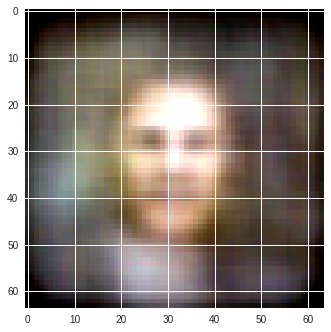

In [0]:
plt.imshow(np.rot90(pred[0].detach().cpu().numpy().T, k=3))

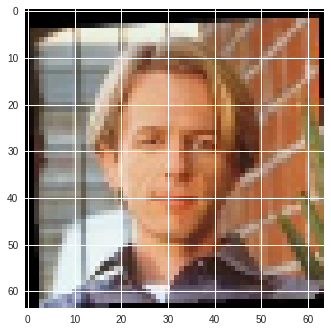

In [0]:
plt.imshow(np.rot90(img[0].detach().cpu().numpy().T, k=3))

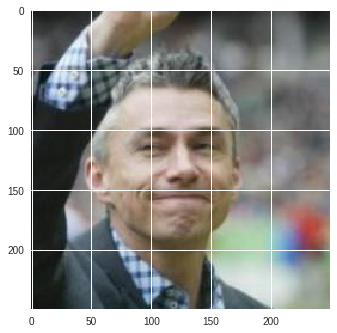

In [0]:
   plt.imshow(img.numpy()[0])

In [0]:
img.shape

torch.Size([1, 250, 250, 3])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            }, "gdrive/My Drive/encoder_project/model_checkpoint.model")

In [0]:
model = AutoEncoder().cuda().double()
optimizer = Opt.SGD(model.parameters(), lr=0.01)

checkpoint = torch.load("gdrive/My Drive/encoder_project/model_checkpoint.model")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']